In [1]:
%run setup.py

/Users/yaguang/micromamba/envs/numax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stars = pd.read_csv('../sample/samples_rg.csv')
vrard = pd.read_csv('../sample/vrard+16.csv')
stars = stars.merge(vrard[['KIC', 'DPi1', 'e_DPi1']], on='KIC', how='left')

# idx = stars['DPi1'].notna() & stars['e_DPi1'].notna()
# stars = stars[idx].reset_index(drop=True)

# stars = stars.loc[idx,:].reset_index(drop=True)
modes = pd.read_csv('../sample/modes_rg.csv')

ebs = pd.read_csv('../sample/samples_eb.csv')

In [3]:
stars

,KIC,Teff_spec,e_Teff_spec,[M/H],e_[M/H],Dnu,e_Dnu,ra,ra_error,dec,...,Teff,e_Teff,luminosity,e_luminosity,numax_yu,e_numax_yu,numax,e_numax,DPi1,e_DPi1
0,1027337,4635.5390,100,0.231188,0.06,6.937,0.014,291.334197,0.009558,36.786600,...,4633,100,27.253188,1.440431,74.21,0.68,73.239252,0.611628,70.1,0.36
1,1163359,4578.9840,100,-0.413422,0.06,2.642,0.015,291.493292,0.010812,36.848781,...,4585,100,89.660979,7.896483,21.43,0.41,21.169614,0.274593,NaN,NaN
2,1294122,4805.9585,100,-0.054198,0.06,7.022,0.016,291.279893,0.007021,36.906973,...,4759,100,27.669848,1.224867,75.62,0.84,73.861258,0.634862,NaN,NaN
3,1294385,4823.5620,100,0.079879,0.06,9.090,0.016,291.339543,0.008559,36.902718,...,4818,100,20.791524,0.735736,106.81,1.08,104.409957,0.905508,NaN,NaN
4,1296068,4586.5454,100,-0.010170,0.06,6.140,0.013,291.686720,0.008105,36.970840,...,4510,100,23.087333,1.313684,59.56,0.49,58.526741,0.357770,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780,12647227,4790.0854,100,-0.460332,0.06,4.342,0.016,290.559287,0.009886,51.780824,...,4830,100,51.209177,1.878490,38.70,0.58,38.086791,0.371699,NaN,NaN
2781,12647352,4524.1772,100,-0.408592,0.06,2.755,0.016,290.621462,0.008077,51.721204,...,4583,100,84.951597,5.261892,22.75,0.30,22.111021,0.186848,NaN,NaN
2782,12735851,4688.1720,100,-0.305272,0.06,4.774,0.012,289.833822,0.009257,51.976219,...,4749,100,39.142495,2.214438,42.71,0.55,42.192120,0.333087,NaN,NaN
2783,12785250,4773.4170,100,-0.374362,0.06,3.857,0.015,290.448639,0.009792,52.093476,...,4739,100,66.922540,6.021725,33.72,0.37,32.650622,0.263937,NaN,NaN


0

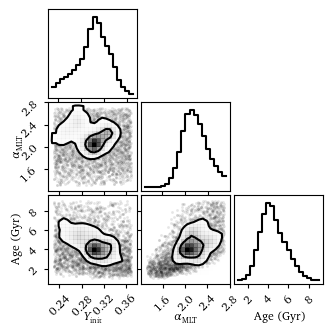

In [151]:
# # ok stars
kic = 10904520
# kic = 5080831

star = stars[stars["KIC"]==kic].iloc[0]

filepath = rootpath+'numax/results_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
data = h5py.File(filepath, 'r')

keys = ['index', 'star_mass', 'radius',  'star_age', 'Yinit', 'Zinit', 'amlt', 
        'fov_core', 'fov_shell', 'Teff', 'luminosity', 'FeH', 'numax_scaling', 
        'Dnu_freq', 'delta_Pg', 'chi2_seismic_l0', 'chi2_seismic_l2', 'chi2_seismic', 'chi2_classical', 'chi2']


data = pd.DataFrame({key:data[key][:] for key in keys}).query('chi2 < 100')

data = h5py.File(filepath, 'r')
data = pd.DataFrame({key:data[key][:] for key in keys}).query('star_age < 9e9')
data['star_age'] = data['star_age']/1e9
data['Xinit'] = 1-data['Yinit']-data['Zinit']

chi2_Teff = (data['Teff']-star['Teff'])**2.0 / star['e_Teff']**2.0
chi2_mh = (data['FeH']-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0
chi2_lum = (data['luminosity']-star['luminosity'])**2.0 / star['e_luminosity']**2.0
chi2_numax = (data['numax_scaling']-star['numax'])**2.0 / star['e_numax']**2.0
chi2_Dnu = (data['Dnu_freq']-star['Dnu'])**2.0 / star['e_Dnu']**2.0
chi2_DPi = (data['delta_Pg']-star['DPi1'])**2.0 / star['e_DPi1']**2.0

# chi2_amlt_18 = (data['amlt']-1.8)**2.0 / 0.1**2.0
# chi2_amlt_22 = (data['amlt']-2.2)**2.0 / 0.1**2.0

chi2_all = (data['chi2_seismic_l0'] + data['chi2_seismic_l2']) + chi2_lum  + chi2_Teff + chi2_mh + chi2_numax + chi2_DPi # + 

scale = 1/3 # 1/5 # 1
data['prob'] = np.exp(-(chi2_all*scale)/2)
# data['prob_amlt_18'] = np.exp(-(chi2_all*scale + chi2_amlt_18)/2)
# data['prob_amlt_22'] = np.exp(-(chi2_all*scale + chi2_amlt_22)/2)

cols = ['Yinit', 'amlt', 'star_age']
labels = [r'$Y_{\rm init}$', r'$\alpha_{\rm MLT}$', r'Age (Gyr)']
m = data['prob'] > 1e-50

fig, axes = plt.subplots(figsize=figsize(column='one', ratio=1), nrows=3, ncols=3, squeeze=False, )
axes = axes.reshape(-1)

fig = corner.corner(data[m][cols].values, weights=data[m]['prob'].values, labels=labels, 
                    smooth=1.5, smooth1d=1.5, levels=(0.393, 0.864), fig=fig);
# fig = corner.corner(data[m][cols].values, weights=data[m]['prob_amlt_18'].values, labels=cols, fig=fig);
# fig = corner.corner(data[m][cols].values, weights=data[m]['prob_amlt_22'].values, labels=cols, fig=fig);

# filename = 'Fig.3_corner.pdf'
# plt.savefig(filename, dpi=300)
# os.system(to_overleaf(filename))